In [1]:
# Setup and Imports
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings
from sklearn.model_selection import GridSearchCV


# Model Training
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)

# --- Configuration ---
DB_PATH = '../../dataset/supervised_dataset.duckdb'
LABELED_TABLE = 'labeled_training_data_new_approach'
TUNED_MODEL_SAVE_PATH = '../../models/supervised/tuned_insider_model.pkl'

sns.set_theme(style="whitegrid")

warnings.filterwarnings("ignore")

In [2]:
# Load Labeled Data
print(f"Loading labeled data from '{LABELED_TABLE}'...")
try:
    con = duckdb.connect(database=DB_PATH, read_only=True)
    df = con.query(f"SELECT * FROM {LABELED_TABLE}").to_df()
    con.close()
    
    df['is_insider'] = df['is_insider'].astype(int)
    
    print("Data loaded successfully.")
    print(f"Dataset shape: {df.shape}")

except Exception as e:
    print(f"--- CRITICAL ERROR: Could not load data ---")
    print(f"Error: {e}")
    raise

Loading labeled data from 'labeled_training_data_new_approach'...
Data loaded successfully.
Dataset shape: (1000, 38)


In [3]:
# Define Features (X) and Target (y)
print("\nDefining features (X) and target (y)...")
y = df['is_insider']
X = df.drop(columns=['user_id', 'is_insider'])
feature_names = X.columns.tolist()


Defining features (X) and target (y)...


In [4]:
# Create Train-Test Split
print("\nCreating stratified 80/20 train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42, # Ensures same split as before
    stratify=y
)

print(f"  Training features: {X_train.shape}")
print(f"  Testing features:  {X_test.shape}")
print("\nTraining set distribution:")
print(y_train.value_counts())
print("\nTesting set distribution:")
print(y_test.value_counts())


Creating stratified 80/20 train-test split...
  Training features: (800, 36)
  Testing features:  (200, 36)

Training set distribution:
is_insider
0    744
1     56
Name: count, dtype: int64

Testing set distribution:
is_insider
0    186
1     14
Name: count, dtype: int64


In [10]:
# Define the Parameter Grid
# It will try every possible combination.

print("\nDefining parameter grid...")

base_scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Base 'scale_pos_weight' is: {base_scale_pos_weight:.2f}")

param_grid = {
    # Force simpler trees
    'max_depth': [3, 4, 5],
    
    # Test fewer trees
    'n_estimators': [100, 200],
    
    # Test different learning rates
    'learning_rate': [0.05, 0.1],

    
    'scale_pos_weight': [base_scale_pos_weight],
    
    # Use a fraction of data rows for each tree
    'subsample': [0.7, 0.8],
    
    # Use a fraction of features (columns) for each tree
    'colsample_bytree': [0.7, 0.8]
}

# 3 * 2 * 2 * 1 * 2 * 2 = 48 combinations
print(f"GridSearch will test {3*2*2*1*2*2} parameter combinations.")


Defining parameter grid (with regularization)...
Base 'scale_pos_weight' is: 13.29
GridSearch will test 48 parameter combinations.


In [11]:
# Initialize and Run GridSearchCV

print("\n--- Starting GridSearchCV ---")

# Initialize the base XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Initialize the GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='average_precision', # Optimize for AUPRC
    cv=3,
    n_jobs=-1, 
    verbose=2  
)

# Run the search
grid_search.fit(X_train, y_train)

print("\n--- GridSearchCV Complete ---")


--- Starting GridSearchCV ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits

--- GridSearchCV Complete ---


In [12]:
# Show Best Results
print("\n--- Best Model Found ---")
print(f"Best AUPRC (avg_precision) on train set: {grid_search.best_score_:.4f}")
print("Best Parameters:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_


--- Best Model Found ---
Best AUPRC (avg_precision) on train set: 0.6932
Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': np.float64(13.285714285714286), 'subsample': 0.7}


In [13]:
# Save the Tuned Model
print(f"\nSaving tuned model to '{TUNED_MODEL_SAVE_PATH}'...")
try:
    with open(TUNED_MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(best_model, f)
    print("Tuned model saved successfully.")
except Exception as e:
    print(f"--- ERROR: Could not save model ---")
    print(f"Error: {e}")


Saving tuned model to '../../models/supervised/tuned_insider_model.pkl'...
Tuned model saved successfully.



--- FINAL EVALUATION (Tuned Model on Test Set) ---

--- Classification Report (Tuned Model) ---
              precision    recall  f1-score   support

  Benign (0)       0.98      0.97      0.98       186
 Insider (1)       0.67      0.71      0.69        14

    accuracy                           0.95       200
   macro avg       0.82      0.84      0.83       200
weighted avg       0.96      0.95      0.96       200


--- Confusion Matrix (Tuned Model) ---


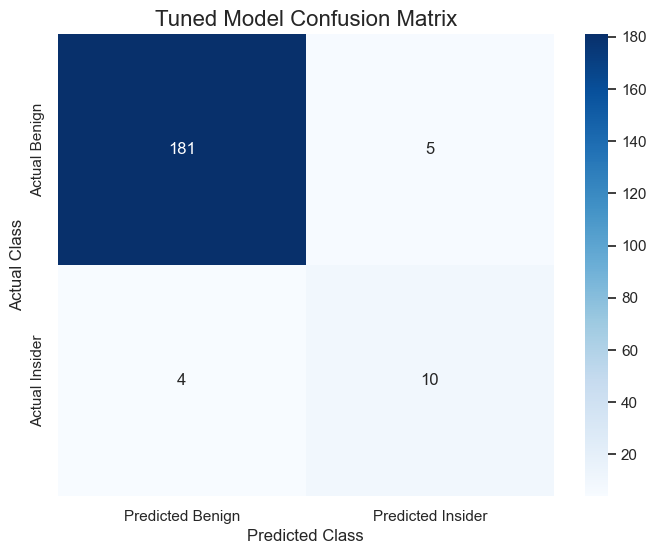


--- Precision-Recall Curve (Tuned Model) ---


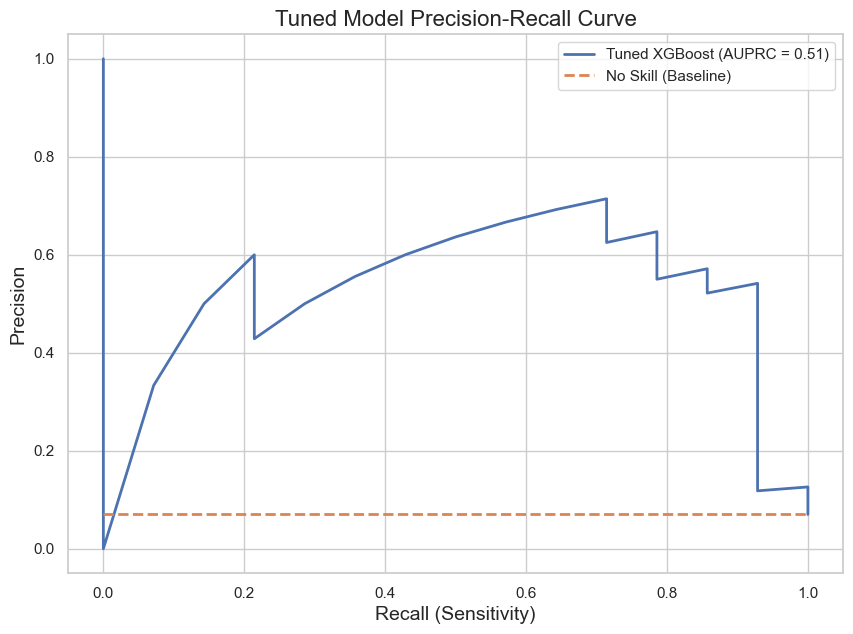

Tuned Model AUPRC: 0.5147
(Baseline model AUPRC was 0.69)

--- Feature Importance (Tuned Model) ---


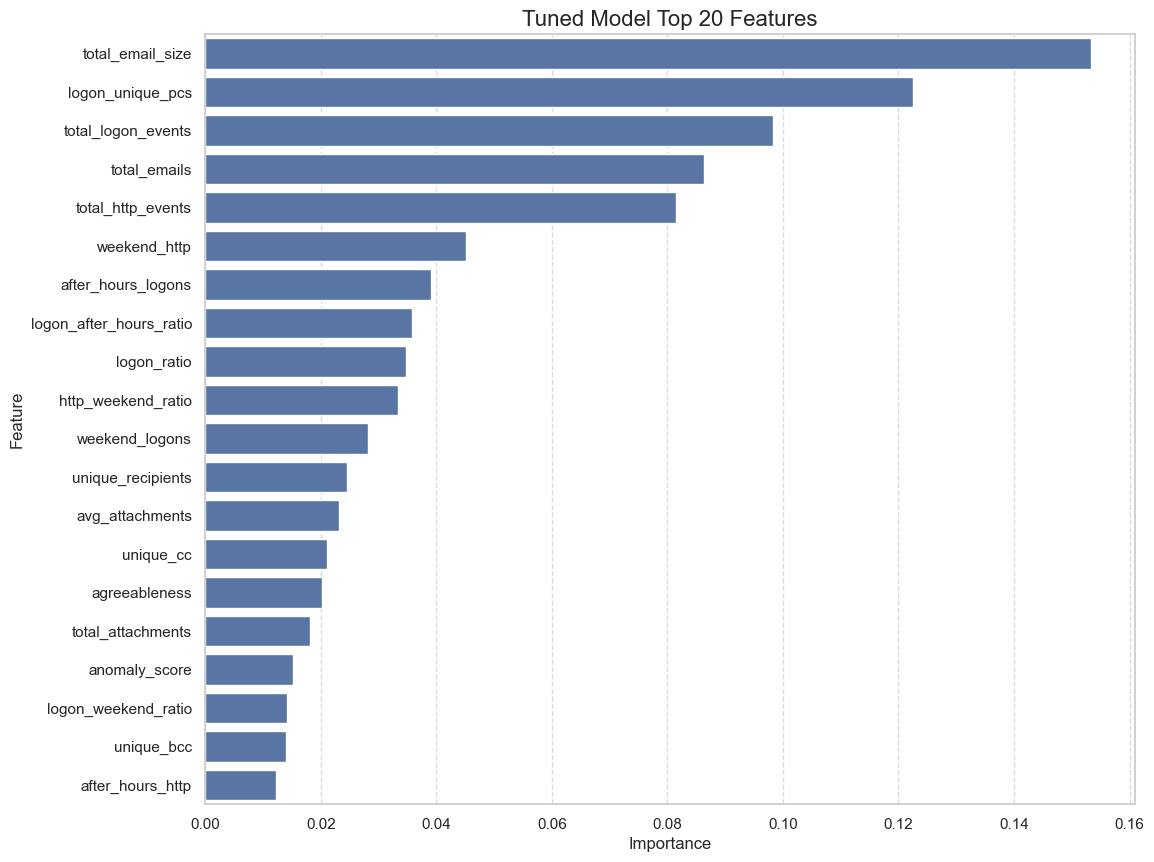

In [14]:
# final Evaluation
print("\n--- Final Evaluation (Tuned Model on Test Set) ---")

# Classification Report
print("\n--- Classification Report (Tuned Model) ---")
y_pred_tuned = best_model.predict(X_test)

print(classification_report(y_test, y_pred_tuned, target_names=["Benign (0)", "Insider (1)"]))

# Confusion Matrix
print("\n--- Confusion Matrix (Tuned Model) ---")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_tuned,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["Predicted Benign", "Predicted Insider"],
    yticklabels=["Actual Benign", "Actual Insider"]
)
plt.title('Tuned Model Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Precision-Recall Curve
print("\n--- Precision-Recall Curve (Tuned Model) ---")
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_pred_proba_tuned)
pr_auc_tuned = auc(recall_tuned, precision_tuned)

plt.figure(figsize=(10, 7))
plt.plot(recall_tuned, precision_tuned, lw=2, label=f'Tuned XGBoost (AUPRC = {pr_auc_tuned:.2f})')
no_skill = (y_test == 1).sum() / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, label='No Skill (Baseline)')

plt.xlabel('Recall (Sensitivity)', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Tuned Model Precision-Recall Curve', fontsize=16)
plt.legend(loc='best')
plt.show()
print(f"Tuned Model AUPRC: {pr_auc_tuned:.4f}")
print(f"(Baseline model AUPRC was 0.69)")

# Feature Importance
print("\n--- Feature Importance (Tuned Model) ---")
importances_tuned = best_model.feature_importances_
feat_imp_df_tuned = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_tuned
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df_tuned.head(20)
)
plt.title('Tuned Model Top 20 Features', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()